## Import bibliotek

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
import warnings
import os
warnings.filterwarnings('ignore')

output_dir = 'heart_output'
os.makedirs(output_dir, exist_ok=True)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Wczytanie danych

In [78]:
print("="*80)
print("1. WCZYTANIE DANYCH")
print("="*80)

df = pd.read_csv('datasets/heart_cleveland_upload.csv')
print(f"\nWymiary datasetu: {df.shape}")
print(f"\nPierwsze wiersze:\n{df.head()}")
print(f"\nTypy danych:\n{df.dtypes}")
print(f"\nInformacje o danych:")
df.info()

1. WCZYTANIE DANYCH

Wymiary datasetu: (297, 14)

Pierwsze wiersze:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   69    1   0       160   234    1        2      131      0      0.1      1   
1   69    0   0       140   239    0        0      151      0      1.8      0   
2   66    0   0       150   226    0        0      114      0      2.6      2   
3   65    1   0       138   282    1        2      174      0      1.4      1   
4   64    1   0       110   211    0        2      144      1      1.8      1   

   ca  thal  condition  
0   1     0          0  
1   2     0          0  
2   0     0          0  
3   1     0          1  
4   0     0          0  

Typy danych:
age            int64
sex            int64
cp             int64
trestbps       int64
chol           int64
fbs            int64
restecg        int64
thalach        int64
exang          int64
oldpeak      float64
slope          int64
ca             int64
thal           int64
conditio

## 2. Czyszczenie danych i obsługa brakujących wartości

Funkcja do:
- Wykrywania brakujących wartości
- Uzupełniania brakujących wartości medianą
- Wykrywania i obsługi wartości odstających (outliers) metodą IQR
- Sprawdzania poprawności zakresów wartości

In [79]:
def clean_and_handle_missing_data(data, numeric_columns=None):
    df_clean = data.copy()
    report = {
        'missing_before': {},
        'missing_after': {},
        'outliers_removed': {},
        'values_imputed': {}
    }
    
    print("\n--- Brakujące wartości ---")
    missing = df_clean.isnull().sum()
    missing_pct = 100 * df_clean.isnull().sum() / len(df_clean)
    missing_table = pd.DataFrame({
        'Brakujące': missing,
        'Procent': missing_pct
    })
    print(missing_table[missing_table['Brakujące'] > 0])
    report['missing_before'] = missing.to_dict()
    
    if numeric_columns is None:
        numeric_columns = df_clean.select_dtypes(include=[np.number]).columns
    
    for col in numeric_columns:
        missing_count = df_clean[col].isnull().sum()
        if missing_count > 0:
            median_value = df_clean[col].median()
            df_clean[col].fillna(median_value, inplace=True)
            report['values_imputed'][col] = missing_count
            print(f"Uzupełniono {missing_count} wartości w kolumnie '{col}' medianą: {median_value:.2f}")
    
    print("\n--- Wartości odstające (metoda IQR) ---")
    for col in numeric_columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)][col]
        
        if len(outliers) > 0:
            print(f"\nKolumna '{col}':")
            print(f"  Zakres prawidłowy: [{lower_bound:.2f}, {upper_bound:.2f}]")
            print(f"  Znaleziono {len(outliers)} wartości odstających")
            
            df_clean.loc[df_clean[col] < lower_bound, col] = lower_bound
            df_clean.loc[df_clean[col] > upper_bound, col] = upper_bound
            report['outliers_removed'][col] = len(outliers)
    
    print("\n--- Sprawdzenie zakresów wartości ---")
    for col in numeric_columns:
        min_val = df_clean[col].min()
        max_val = df_clean[col].max()
        print(f"{col}: min={min_val:.2f}, max={max_val:.2f}")
        
        if min_val < 0 and col not in ['oldpeak']:
            print(f"  UWAGA: Znaleziono wartości ujemne w '{col}'")
    
    report['missing_after'] = df_clean.isnull().sum().to_dict()
    
    return df_clean, report

In [80]:
print("="*80)
print("2. CZYSZCZENIE DANYCH I OBSŁUGA BRAKUJĄCYCH WARTOŚCI")
print("="*80)

df_clean, cleaning_report = clean_and_handle_missing_data(df)

print("\n--- Podsumowanie czyszczenia ---")
print(f"Wymiary po czyszczeniu: {df_clean.shape}")
print(f"Uzupełnione kolumny: {list(cleaning_report['values_imputed'].keys())}")
print(f"Kolumny z usuniętymi outliers: {list(cleaning_report['outliers_removed'].keys())}")

2. CZYSZCZENIE DANYCH I OBSŁUGA BRAKUJĄCYCH WARTOŚCI

--- Brakujące wartości ---
Empty DataFrame
Columns: [Brakujące, Procent]
Index: []

--- Wartości odstające (metoda IQR) ---

Kolumna 'cp':
  Zakres prawidłowy: [0.50, 4.50]
  Znaleziono 23 wartości odstających

Kolumna 'trestbps':
  Zakres prawidłowy: [90.00, 170.00]
  Znaleziono 9 wartości odstających

Kolumna 'chol':
  Zakres prawidłowy: [113.50, 373.50]
  Znaleziono 5 wartości odstających

Kolumna 'fbs':
  Zakres prawidłowy: [0.00, 0.00]
  Znaleziono 43 wartości odstających

Kolumna 'thalach':
  Zakres prawidłowy: [83.50, 215.50]
  Znaleziono 1 wartości odstających

Kolumna 'oldpeak':
  Zakres prawidłowy: [-2.40, 4.00]
  Znaleziono 5 wartości odstających

Kolumna 'ca':
  Zakres prawidłowy: [-1.50, 2.50]
  Znaleziono 20 wartości odstających

--- Sprawdzenie zakresów wartości ---
age: min=29.00, max=77.00
sex: min=0.00, max=1.00
cp: min=0.50, max=3.00
trestbps: min=94.00, max=170.00
chol: min=126.00, max=373.50
fbs: min=0.00, max=0

## 3. Statystyki opisowe

Obliczenie:
- Zakresów wartości (min-max)
- Wartości średnich i odchylenia standardowego
- Mediany
- Kwartyli Q1, Q3
- Kwantyli rzędu 0.1, 0.9

In [81]:
def calculate_descriptive_statistics(data):
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    
    stats_dict = {
        'Min': data[numeric_cols].min(),
        'Max': data[numeric_cols].max(),
        'Zakres': data[numeric_cols].max() - data[numeric_cols].min(),
        'Średnia': data[numeric_cols].mean(),
        'Odchylenie std': data[numeric_cols].std(),
        'Mediana': data[numeric_cols].median(),
        'Q1 (25%)': data[numeric_cols].quantile(0.25),
        'Q3 (75%)': data[numeric_cols].quantile(0.75),
        'IQR': data[numeric_cols].quantile(0.75) - data[numeric_cols].quantile(0.25),
        'Kwantyl 0.1': data[numeric_cols].quantile(0.1),
        'Kwantyl 0.9': data[numeric_cols].quantile(0.9),
    }
    
    stats_df = pd.DataFrame(stats_dict).T
    return stats_df

In [82]:
print("="*80)
print("3. STATYSTYKI OPISOWE")
print("="*80)

stats_df = calculate_descriptive_statistics(df_clean)
print("\nStatystyki opisowe dla wszystkich zmiennych numerycznych:")
print(stats_df.round(2))

stats_df.round(2).to_csv(f'{output_dir}/descriptive_statistics.csv')
print(f"\n✓ Statystyki zapisane do pliku: {output_dir}/descriptive_statistics.csv")

3. STATYSTYKI OPISOWE

Statystyki opisowe dla wszystkich zmiennych numerycznych:
                  age   sex    cp  trestbps    chol  fbs  restecg  thalach  \
Min             29.00  0.00  0.50     94.00  126.00  0.0     0.00    83.50   
Max             77.00  1.00  3.00    170.00  373.50  0.0     2.00   202.00   
Zakres          48.00  1.00  2.50     76.00  247.50  0.0     2.00   118.50   
Średnia         54.54  0.68  2.20    131.34  246.26  0.0     1.00   149.64   
Odchylenie std   9.05  0.47  0.88     16.80   47.84  0.0     0.99    22.81   
Mediana         56.00  1.00  2.00    130.00  243.00  0.0     1.00   153.00   
Q1 (25%)        48.00  0.00  2.00    120.00  211.00  0.0     0.00   133.00   
Q3 (75%)        61.00  1.00  3.00    140.00  276.00  0.0     2.00   166.00   
IQR             13.00  1.00  1.00     20.00   65.00  0.0     2.00    33.00   
Kwantyl 0.1     42.00  0.00  1.00    110.00  190.40  0.0     0.00   116.00   
Kwantyl 0.9     66.00  1.00  3.00    152.80  309.00  0.0     

## 4. Współczynnik korelacji liniowej Pearsona

Analiza zależności między parami zmiennych

In [83]:
def calculate_correlations(data, threshold=0.3):
    numeric_data = data.select_dtypes(include=[np.number])
    correlation_matrix = numeric_data.corr(method='pearson')
    
    print("\nMacierz korelacji Pearsona:")
    print(correlation_matrix.round(3))
    
    print(f"\n--- Silne korelacje (|r| > {threshold}) ---")
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) > threshold:
                col1 = correlation_matrix.columns[i]
                col2 = correlation_matrix.columns[j]
                print(f"{col1} <-> {col2}: r = {corr_value:.3f}")
    
    return correlation_matrix

In [84]:
print("="*80)
print("4. WSPÓŁCZYNNIK KORELACJI LINIOWEJ PEARSONA")
print("="*80)

correlation_matrix = calculate_correlations(df_clean, threshold=0.3)

4. WSPÓŁCZYNNIK KORELACJI LINIOWEJ PEARSONA

Macierz korelacji Pearsona:
             age    sex     cp  trestbps   chol  fbs  restecg  thalach  exang  \
age        1.000 -0.092  0.127     0.298  0.194  NaN    0.150   -0.394  0.096   
sex       -0.092  1.000  0.024    -0.058 -0.182  NaN    0.034   -0.060  0.144   
cp         0.127  0.024  1.000    -0.020  0.074  NaN    0.080   -0.359  0.398   
trestbps   0.298 -0.058 -0.020     1.000  0.143  NaN    0.148   -0.056  0.054   
chol       0.194 -0.182  0.074     0.143  1.000  NaN    0.156   -0.009  0.075   
fbs          NaN    NaN    NaN       NaN    NaN  NaN      NaN      NaN    NaN   
restecg    0.150  0.034  0.080     0.148  0.156  NaN    1.000   -0.075  0.082   
thalach   -0.394 -0.060 -0.359    -0.056 -0.009  NaN   -0.075    1.000 -0.388   
exang      0.096  0.144  0.398     0.054  0.075  NaN    0.082   -0.388  1.000   
oldpeak    0.200  0.116  0.234     0.179  0.041  NaN    0.117   -0.355  0.301   
slope      0.159  0.033  0.175     0

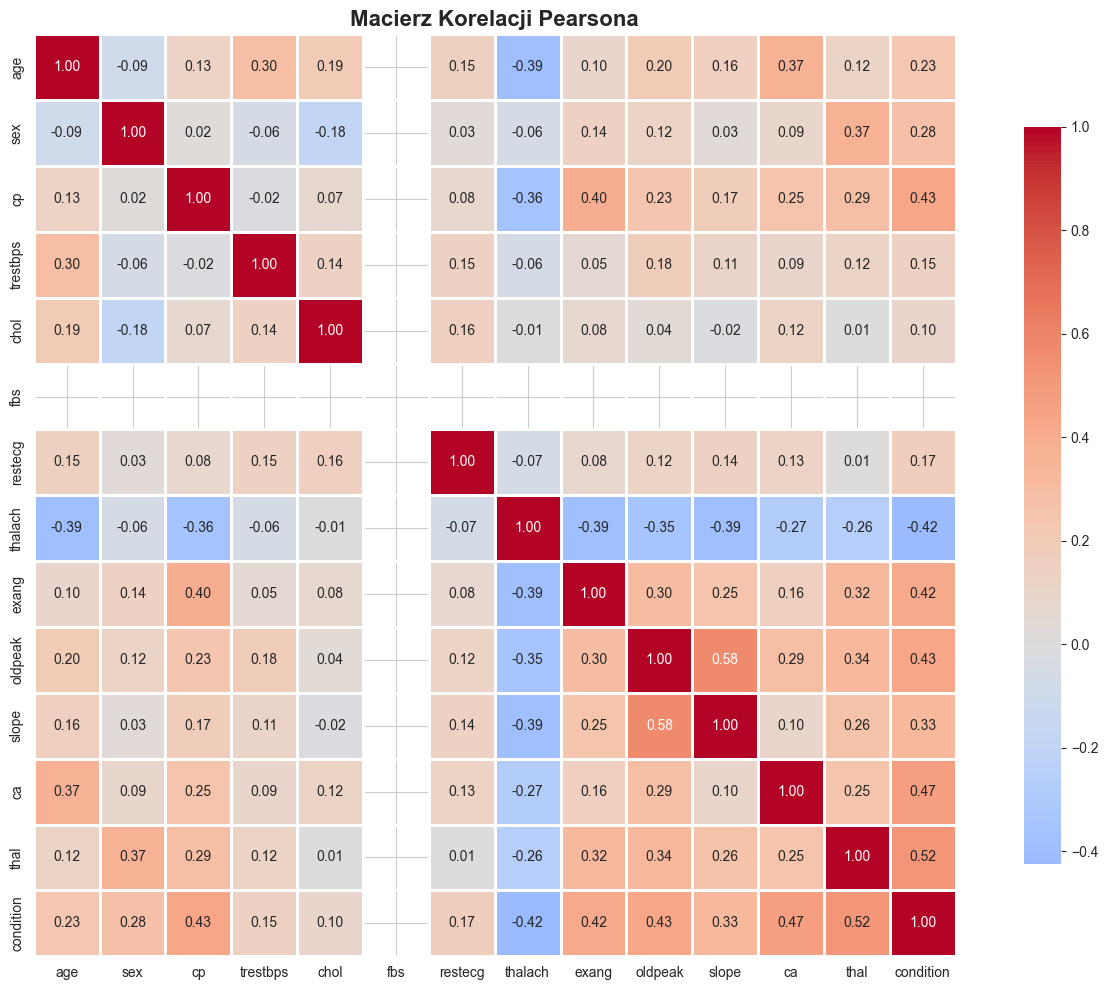

✓ Wykres zapisany: heart_output/correlation_heatmap.png


In [85]:
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Macierz Korelacji Pearsona', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{output_dir}/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Wykres zapisany: {output_dir}/correlation_heatmap.png")

## 5. Prosta regresja liniowa

Wyznaczenie wzorów regresji dla wybranych par zmiennych

In [86]:
def perform_linear_regression(data, x_col, y_col):
    X = data[[x_col]].values
    y = data[y_col].values
    
    mask = ~(np.isnan(X.flatten()) | np.isnan(y))
    X = X[mask].reshape(-1, 1)
    y = y[mask]
    
    model = LinearRegression()
    model.fit(X, y)
    
    y_pred = model.predict(X)
    
    a = model.coef_[0]
    b = model.intercept_
    
    r2 = model.score(X, y)
    
    correlation = np.corrcoef(X.flatten(), y)[0, 1]
    
    formula = f"y = {a:.4f}x + {b:.4f}"
    
    results = {
        'model': model,
        'formula': formula,
        'coefficient': a,
        'intercept': b,
        'r2_score': r2,
        'correlation': correlation,
        'X': X,
        'y': y,
        'y_pred': y_pred
    }
    
    print(f"\nRegresja liniowa: {y_col} ~ {x_col}")
    print(f"Wzór regresji: {formula}")
    print(f"Współczynnik kierunkowy (a): {a:.4f}")
    print(f"Wyraz wolny (b): {b:.4f}")
    print(f"R² score: {r2:.4f}")
    print(f"Korelacja Pearsona: {correlation:.4f}")
    
    return results

In [87]:
print("="*80)
print("5. PROSTA REGRESJA LINIOWA")
print("="*80)

regression_pairs = [
    ('age', 'trestbps'),
    ('age', 'chol'),
    ('trestbps', 'chol'),
    ('age', 'thalach')
]

regression_results = {}
for x_col, y_col in regression_pairs:
    if x_col in df_clean.columns and y_col in df_clean.columns:
        regression_results[f"{y_col}~{x_col}"] = perform_linear_regression(df_clean, x_col, y_col)

5. PROSTA REGRESJA LINIOWA

Regresja liniowa: trestbps ~ age
Wzór regresji: y = 0.5534x + 101.1591
Współczynnik kierunkowy (a): 0.5534
Wyraz wolny (b): 101.1591
R² score: 0.0889
Korelacja Pearsona: 0.2981

Regresja liniowa: chol ~ age
Wzór regresji: y = 1.0275x + 190.2164
Współczynnik kierunkowy (a): 1.0275
Wyraz wolny (b): 190.2164
R² score: 0.0378
Korelacja Pearsona: 0.1944

Regresja liniowa: chol ~ trestbps
Wzór regresji: y = 0.4072x + 192.7826
Współczynnik kierunkowy (a): 0.4072
Wyraz wolny (b): 192.7826
R² score: 0.0205
Korelacja Pearsona: 0.1430

Regresja liniowa: thalach ~ age
Wzór regresji: y = -0.9938x + 203.8461
Współczynnik kierunkowy (a): -0.9938
Wyraz wolny (b): 203.8461
R² score: 0.1555
Korelacja Pearsona: -0.3943


## 6. Wizualizacje danych

### 6.1 Wykresy kołowe - rozkład zmiennych kategorycznych

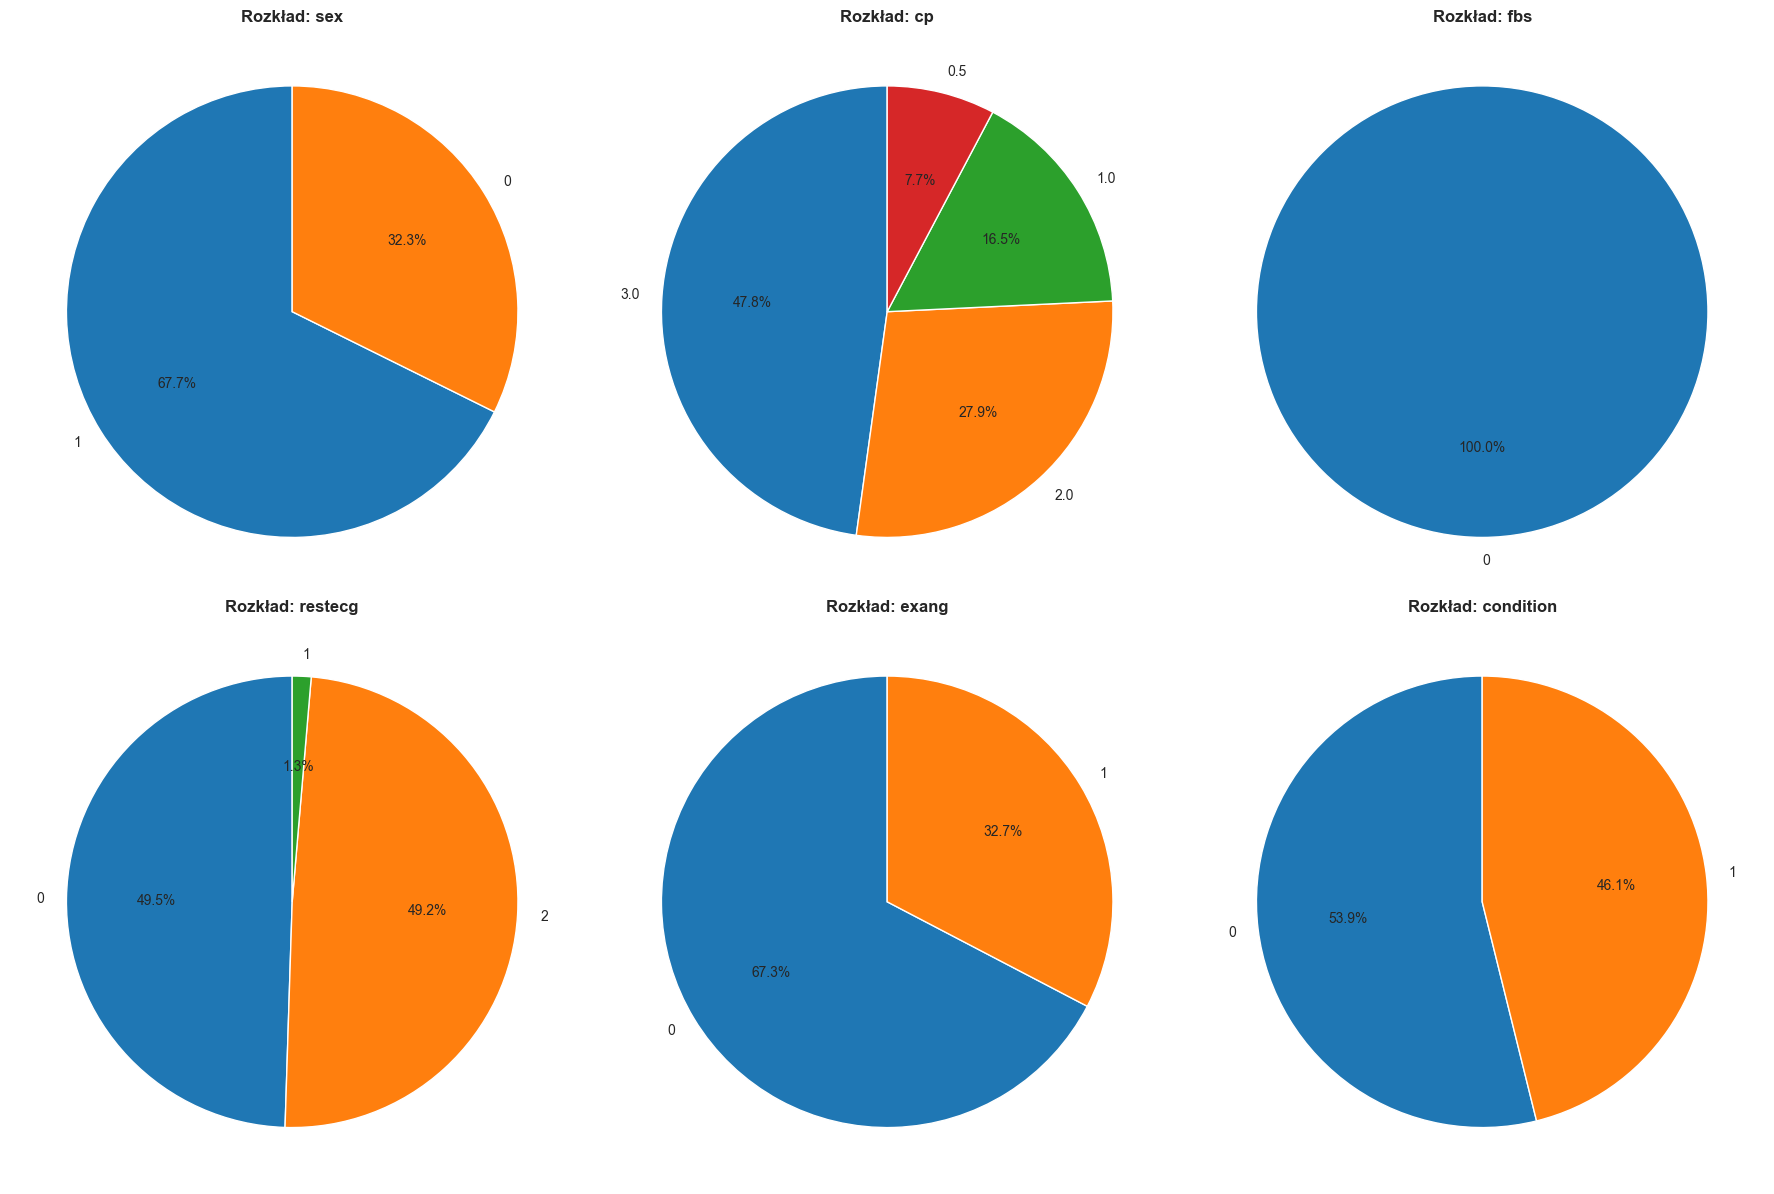

✓ Wykres zapisany: heart_output/pie_bar_charts.png


In [88]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'condition']
for idx, col in enumerate(categorical_cols):
    if col in df_clean.columns:
        ax = axes[idx // 3, idx % 3]
        value_counts = df_clean[col].value_counts()
        ax.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
        ax.set_title(f'Rozkład: {col}', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{output_dir}/pie_bar_charts.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Wykres zapisany: {output_dir}/pie_bar_charts.png")

### 6.2 Wykresy słupkowe - liczebność w klasach

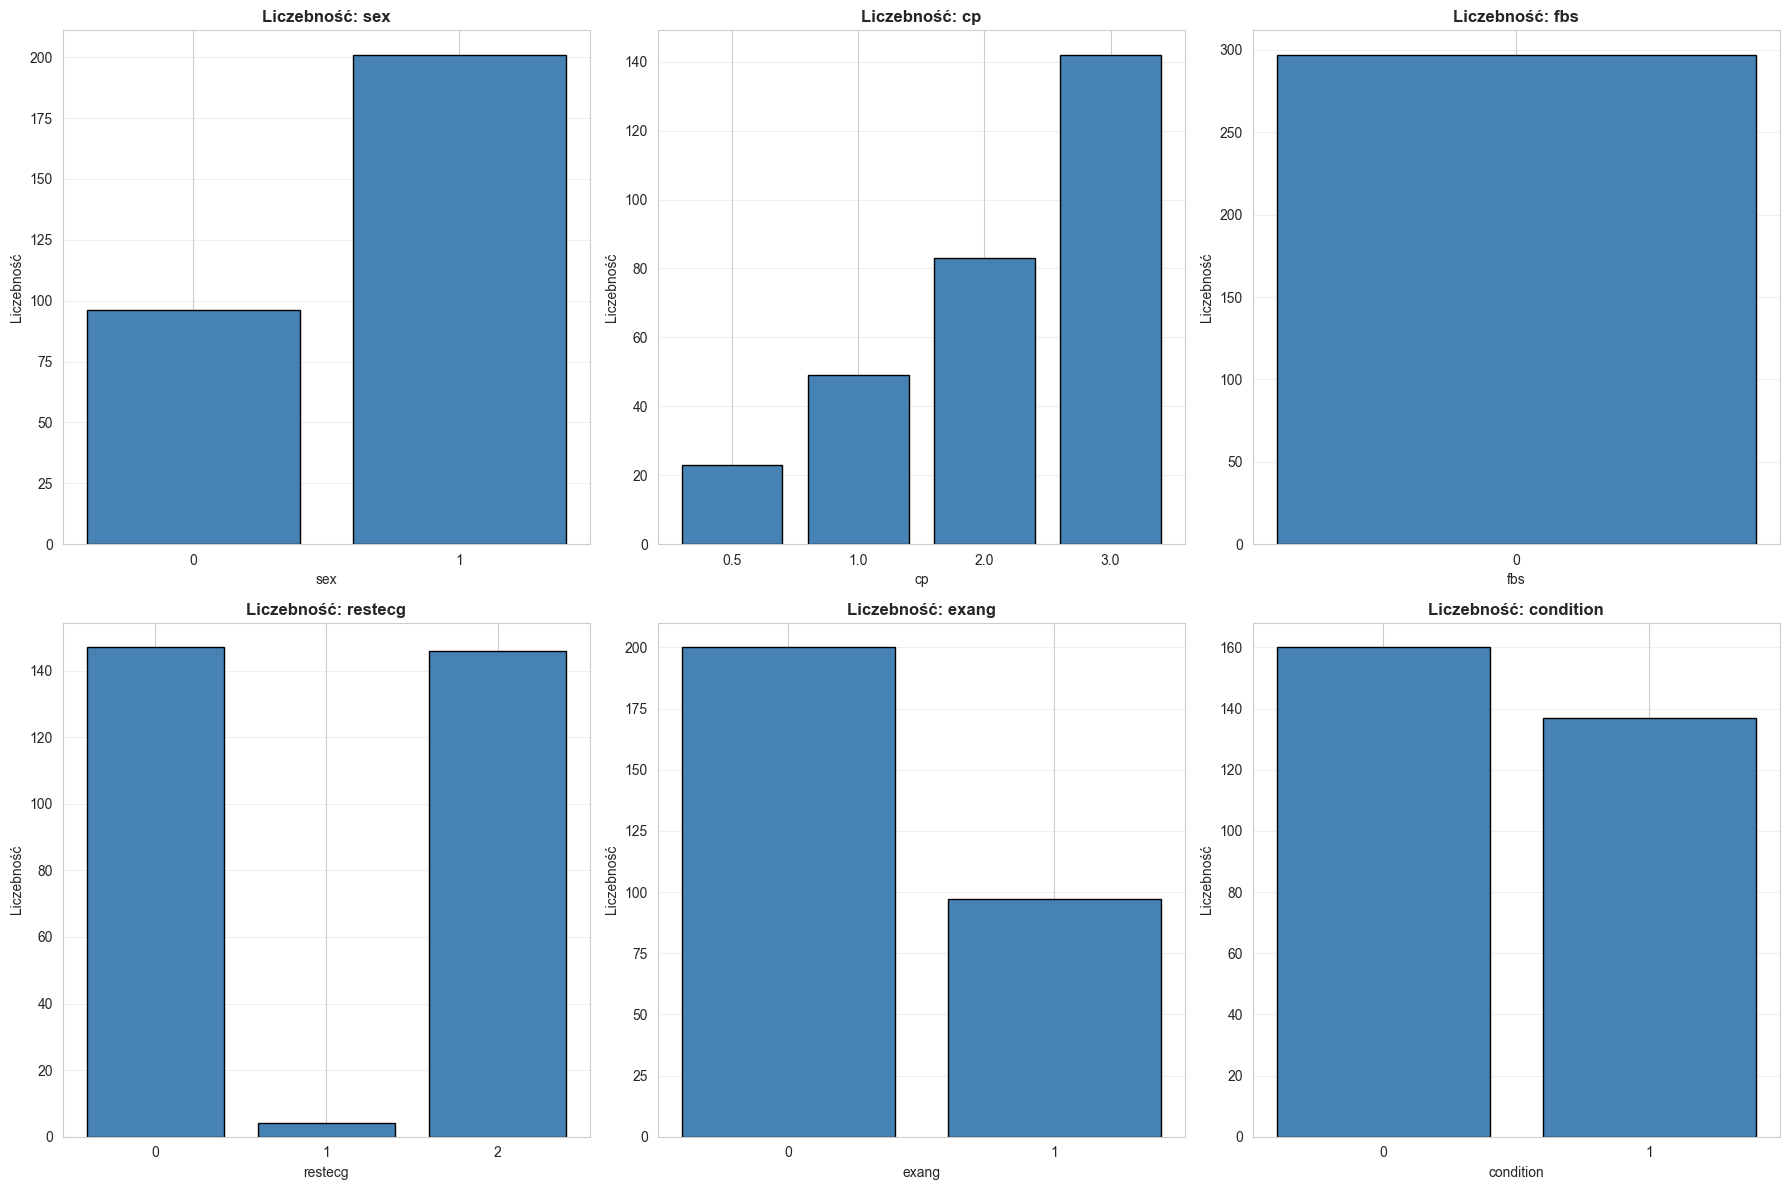

In [89]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'condition']
for idx, col in enumerate(categorical_cols):
    if col in df_clean.columns:
        ax = axes[idx // 3, idx % 3]
        value_counts = df_clean[col].value_counts().sort_index()
        ax.bar(range(len(value_counts)), value_counts.values, color='steelblue', edgecolor='black')
        ax.set_xticks(range(len(value_counts)))
        ax.set_xticklabels(value_counts.index)
        ax.set_xlabel(col)
        ax.set_ylabel('Liczebność')
        ax.set_title(f'Liczebność: {col}', fontweight='bold')
        ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 6.3 Szeregi czasowe (sortowane po wieku)

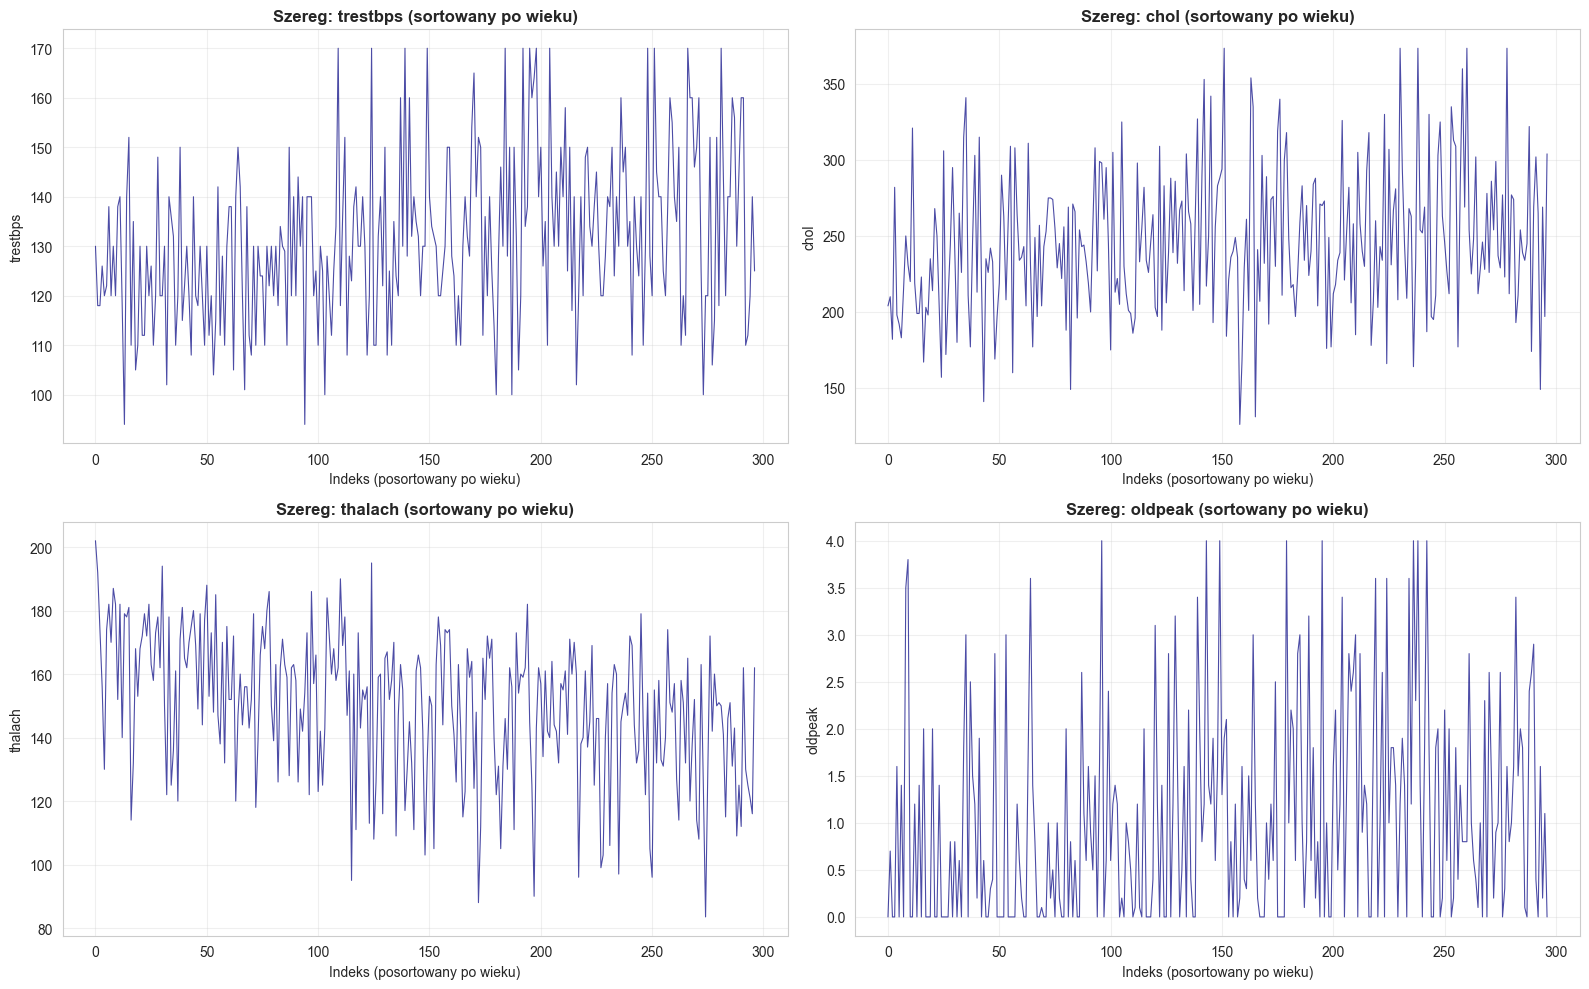

In [90]:
df_sorted = df_clean.sort_values('age').reset_index(drop=True)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

time_series_vars = ['trestbps', 'chol', 'thalach', 'oldpeak']
for idx, var in enumerate(time_series_vars):
    if var in df_sorted.columns:
        ax = axes[idx // 2, idx % 2]
        ax.plot(df_sorted.index, df_sorted[var], linewidth=0.8, alpha=0.7, color='navy')
        ax.set_xlabel('Indeks (posortowany po wieku)')
        ax.set_ylabel(var)
        ax.set_title(f'Szereg: {var} (sortowany po wieku)', fontweight='bold')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 6.4 Histogramy zmiennych

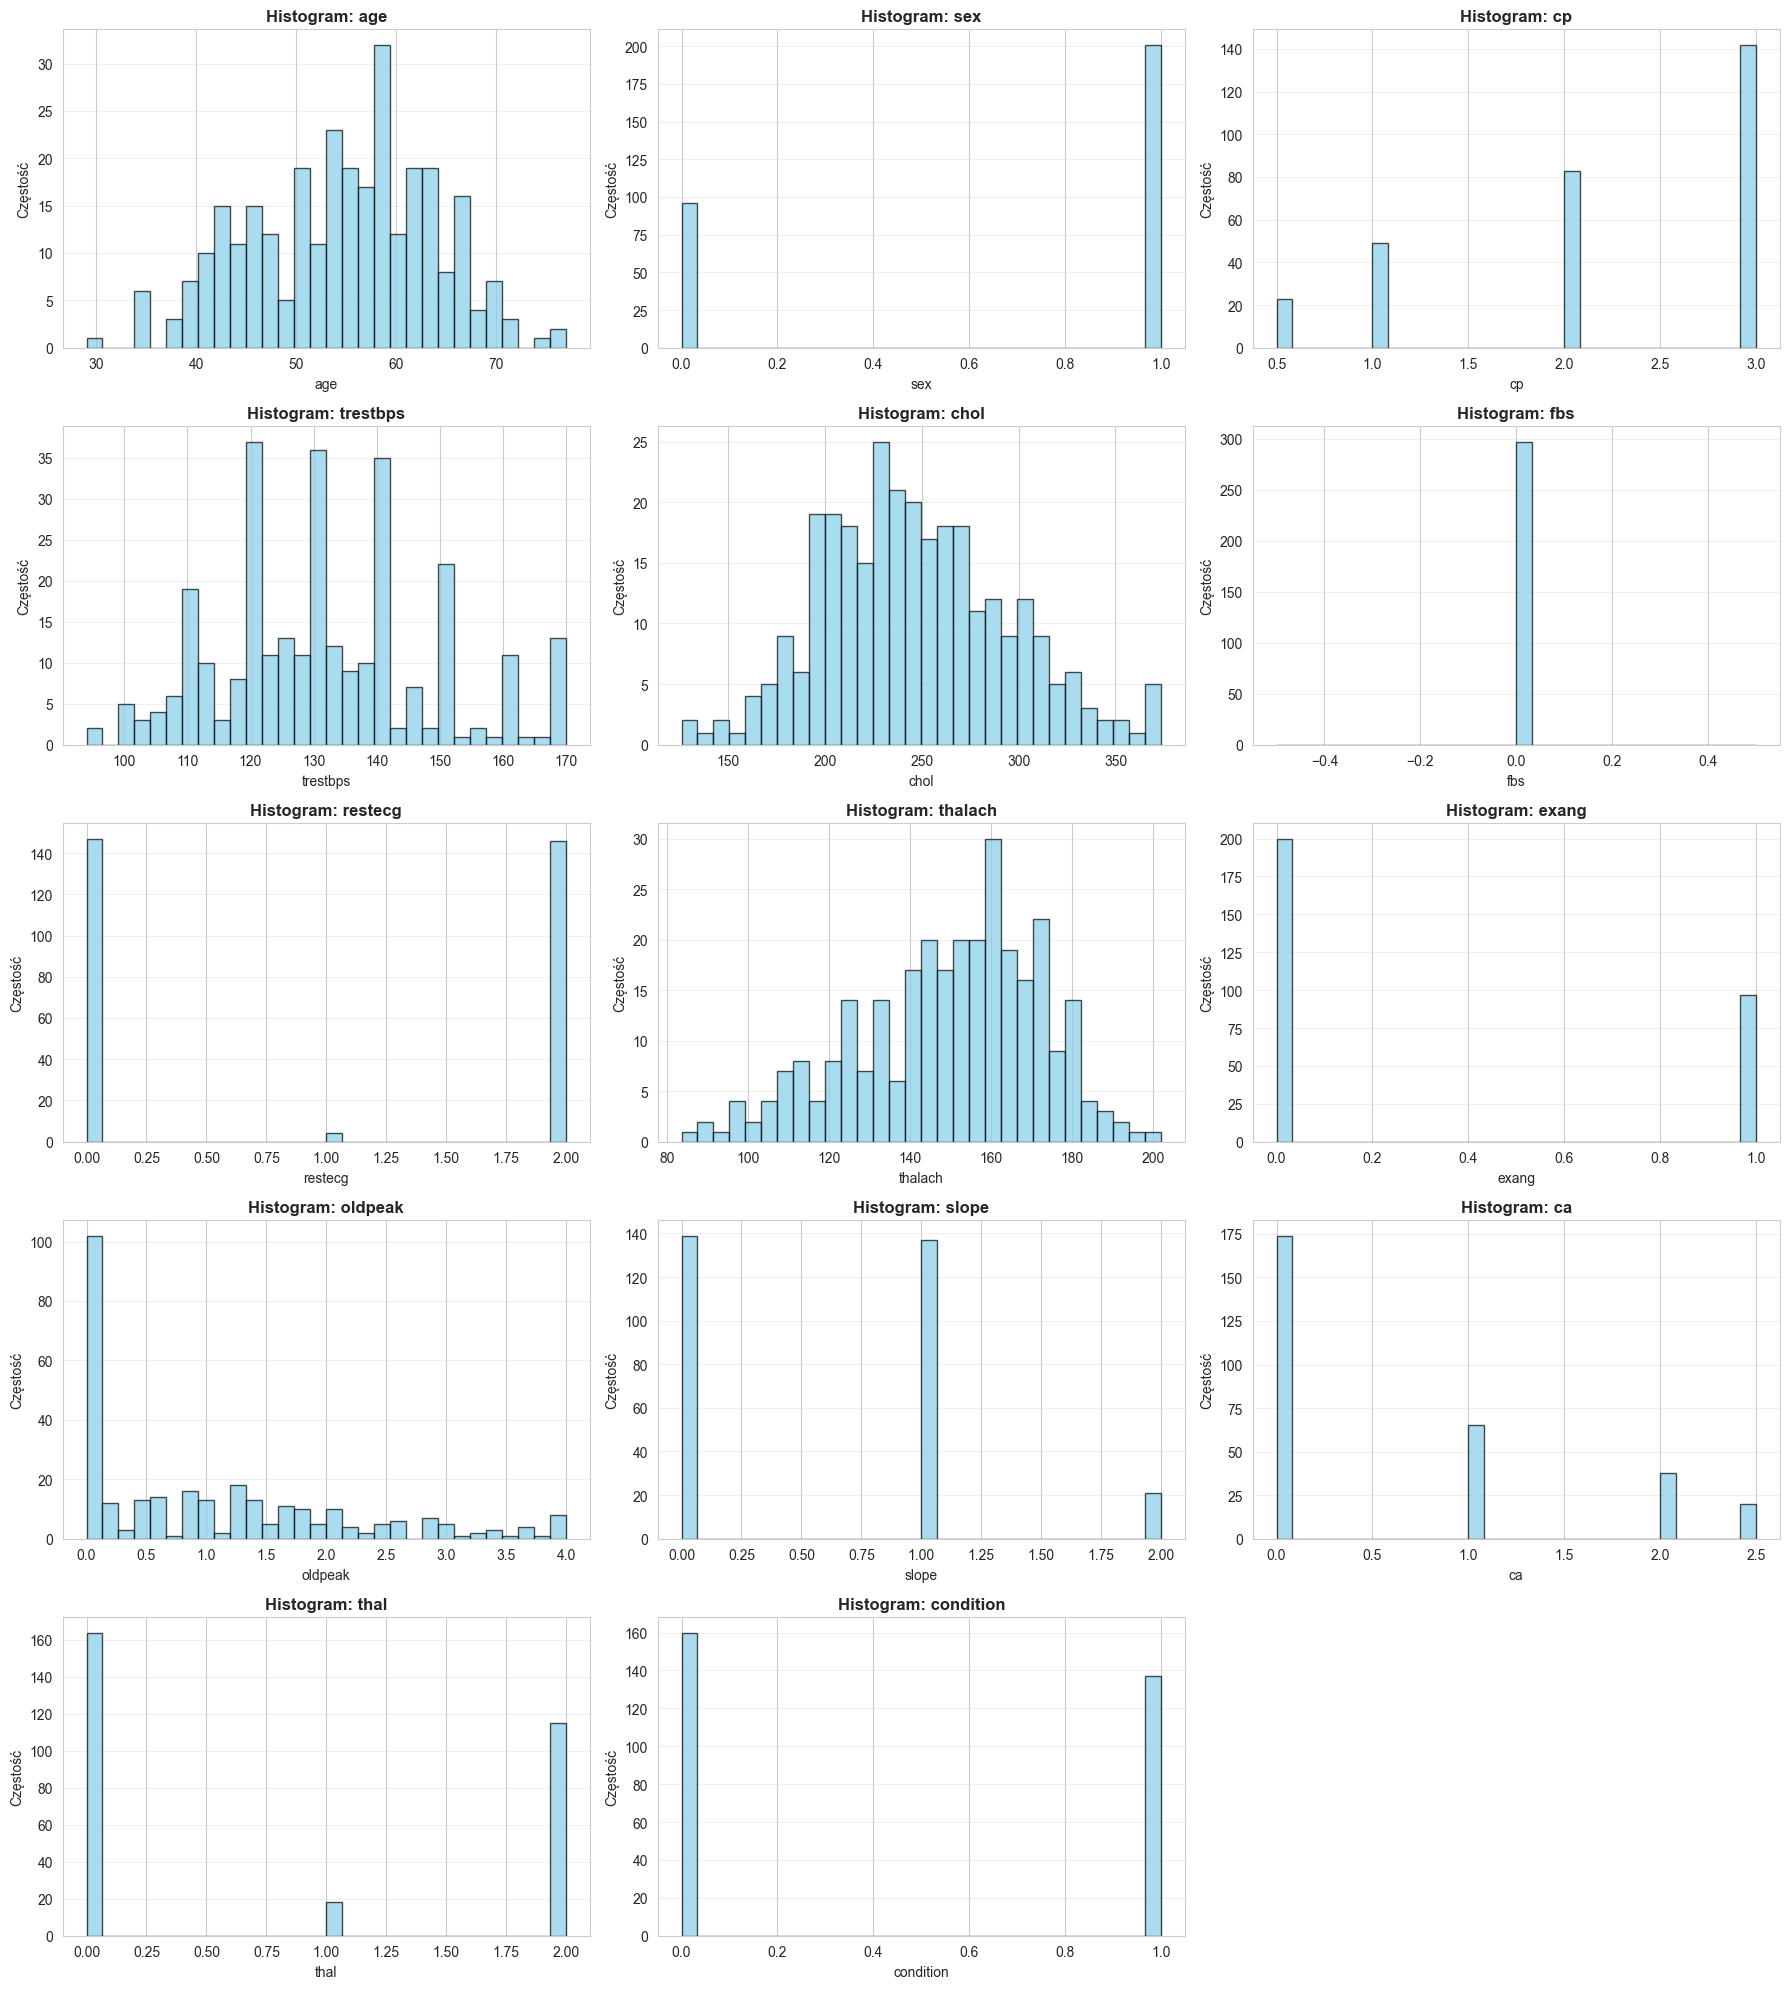

✓ Wykres zapisany: heart_output/histograms.png


In [91]:
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
n_cols = len(numeric_cols)
n_rows = (n_cols + 2) // 3

fig, axes = plt.subplots(n_rows, 3, figsize=(18, n_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    ax = axes[idx]
    ax.hist(df_clean[col].dropna(), bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    ax.set_xlabel(col)
    ax.set_ylabel('Częstość')
    ax.set_title(f'Histogram: {col}', fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

for idx in range(len(numeric_cols), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(f'{output_dir}/histograms.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Wykres zapisany: {output_dir}/histograms.png")

### 6.5 Wykresy pudełkowe (boxplots)

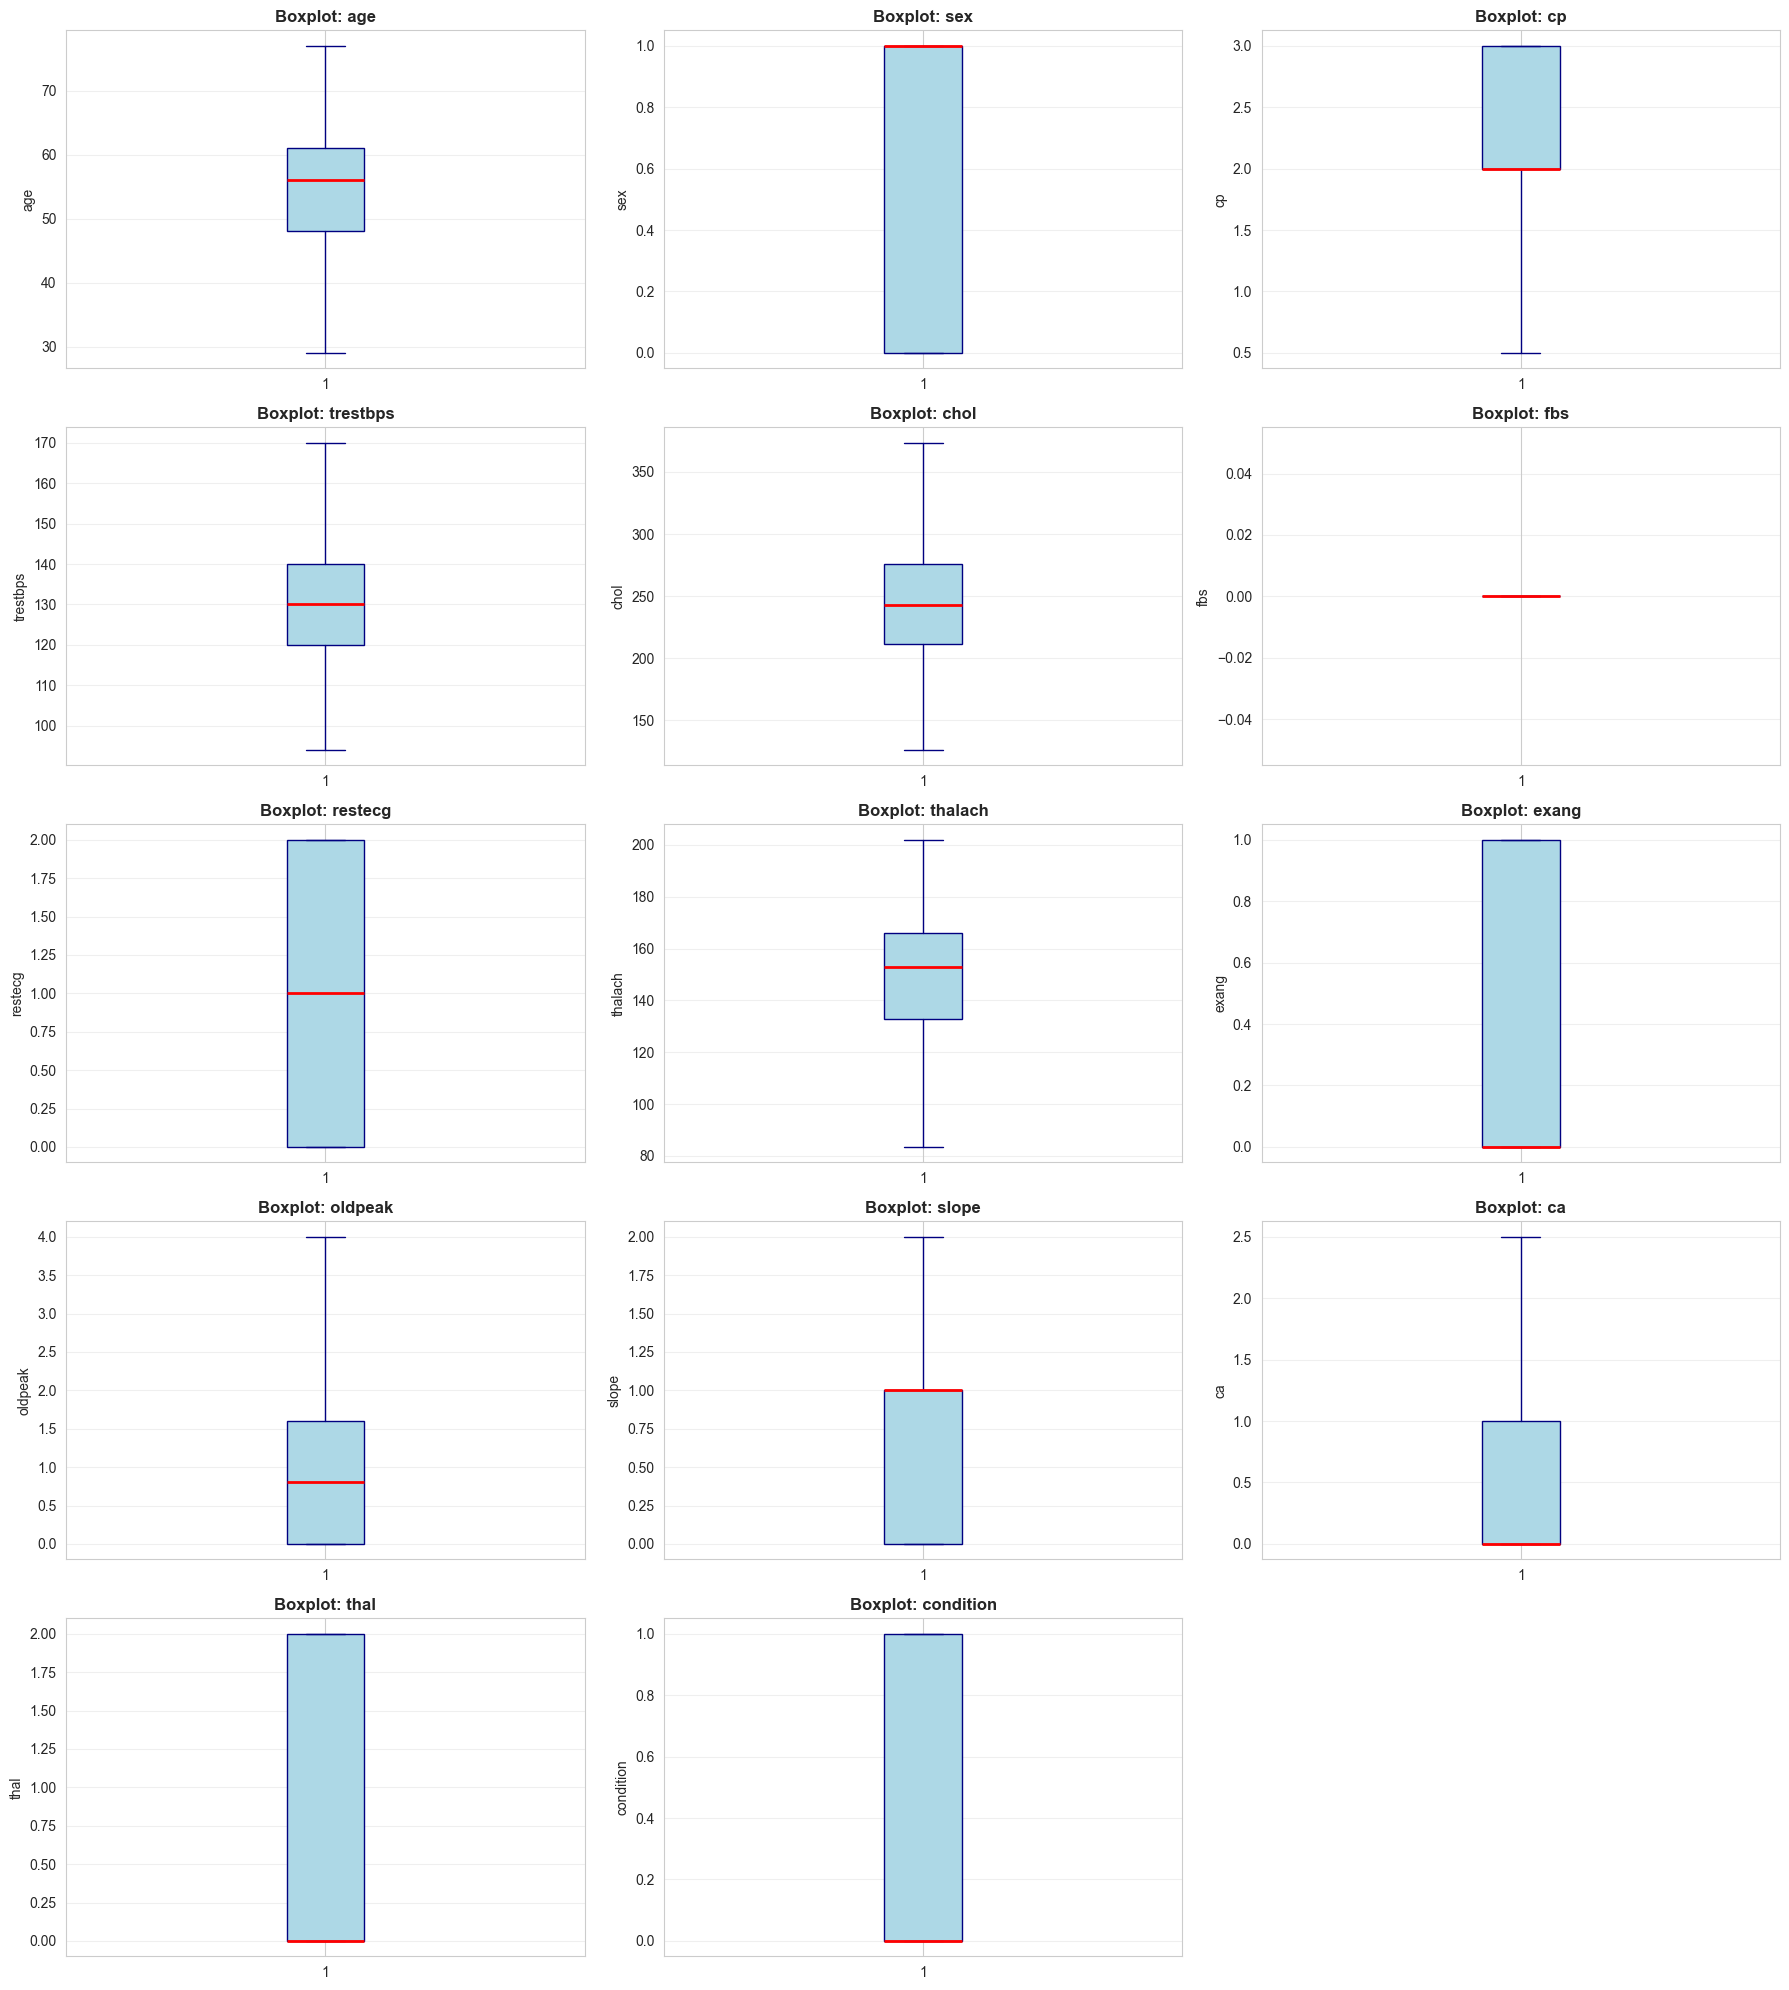

✓ Wykres zapisany: heart_output/boxplots.png


In [92]:
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
n_cols = len(numeric_cols)
n_rows = (n_cols + 2) // 3

fig, axes = plt.subplots(n_rows, 3, figsize=(18, n_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    ax = axes[idx]
    ax.boxplot(df_clean[col].dropna(), vert=True, patch_artist=True,
               boxprops=dict(facecolor='lightblue', color='navy'),
               medianprops=dict(color='red', linewidth=2),
               whiskerprops=dict(color='navy'),
               capprops=dict(color='navy'))
    ax.set_ylabel(col)
    ax.set_title(f'Boxplot: {col}', fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

for idx in range(len(numeric_cols), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(f'{output_dir}/boxplots.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Wykres zapisany: {output_dir}/boxplots.png")

### 6.6 Wykresy wiolinowe (violin plots)

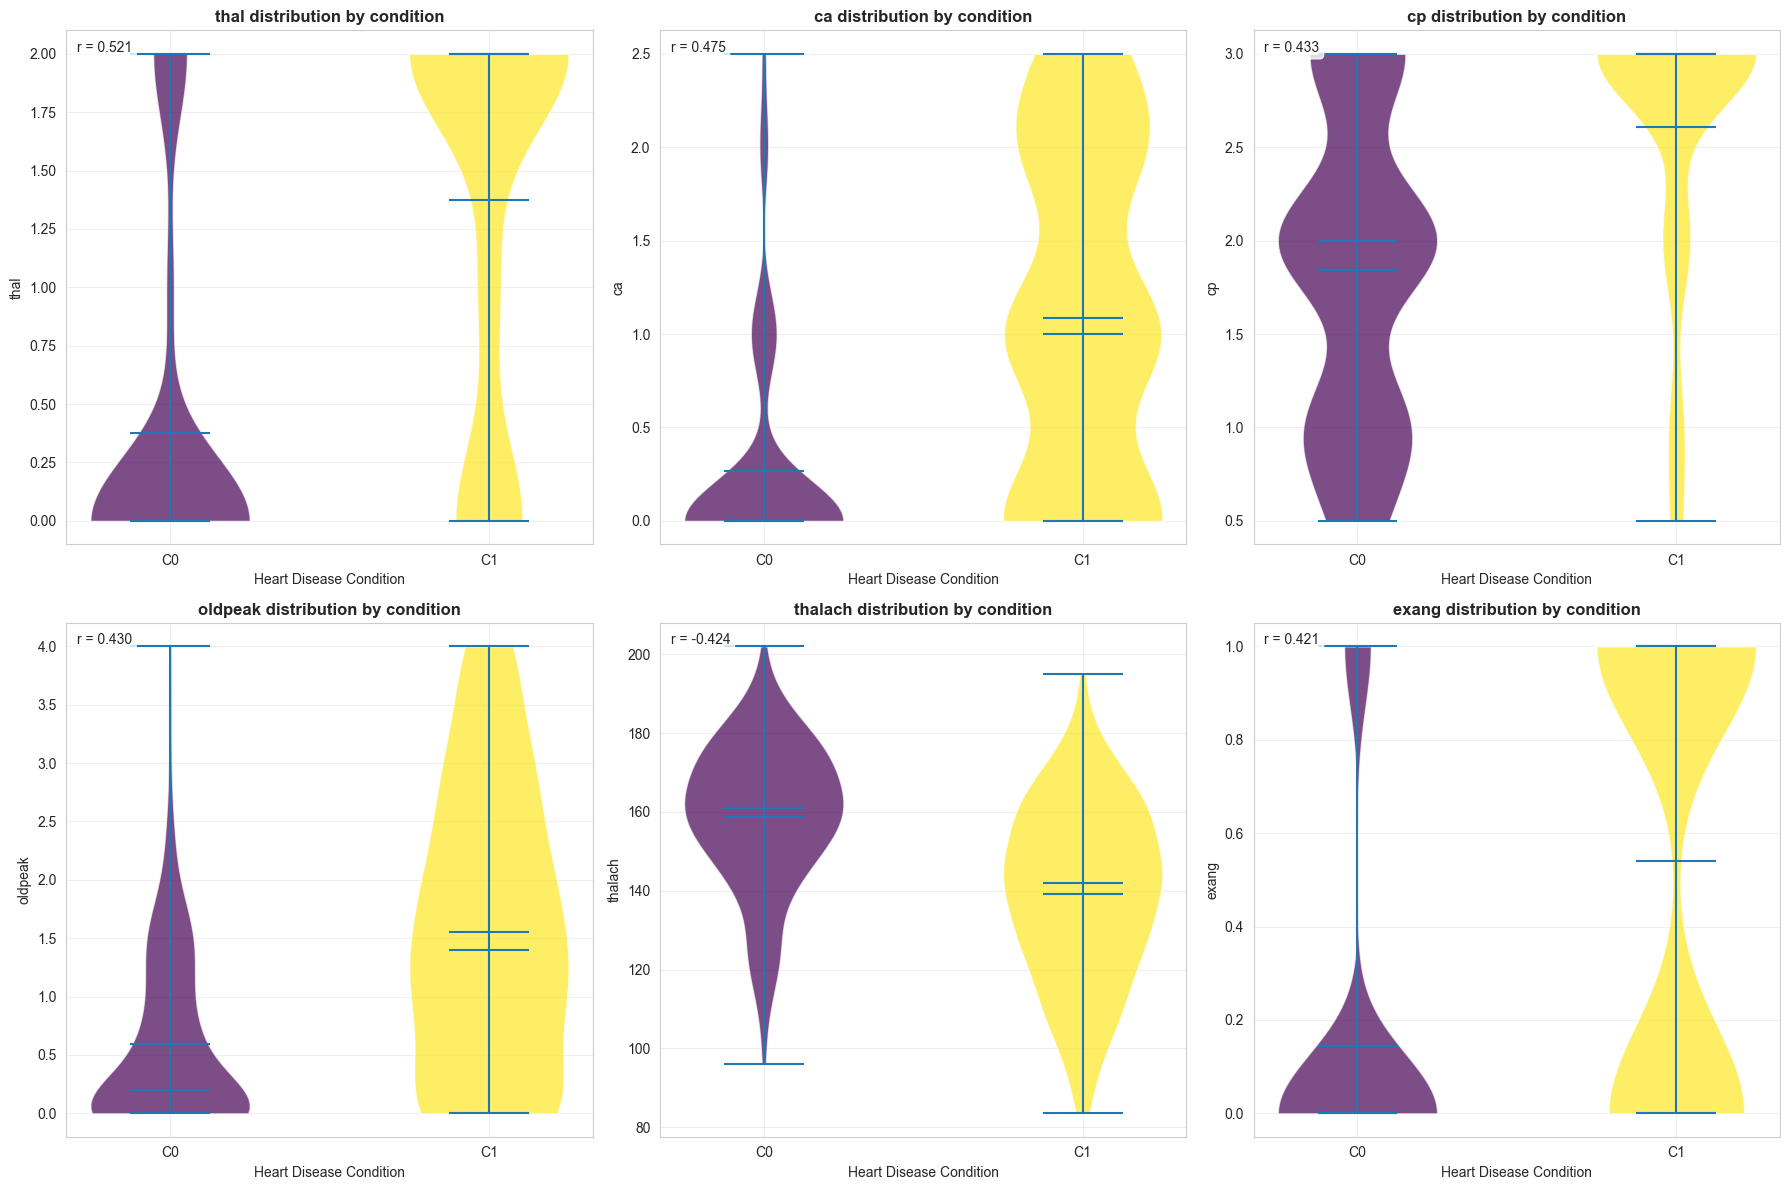

✓ Wykres zapisany: heart_output/violin_plots_1.png


In [93]:
numeric_columns = [col for col in df_clean.select_dtypes(include=[np.number]).columns if col != 'condition']
condition_levels = sorted(df_clean['condition'].unique())

correlations = df_clean[numeric_columns].corrwith(df_clean['condition']).abs().sort_values(ascending=False)
top_variables = correlations.head(6).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, variable in enumerate(top_variables):
    data_for_violin = []
    labels_for_violin = []
    
    for condition in condition_levels:
        subset_data = df_clean[df_clean['condition'] == condition][variable].values
        if len(subset_data) > 5:
            data_for_violin.append(subset_data)
            labels_for_violin.append(f'C{condition}')
    
    parts = axes[i].violinplot(data_for_violin, positions=range(1, len(data_for_violin)+1),
                              showmeans=True, showextrema=True, showmedians=True)
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(data_for_violin)))
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_alpha(0.7)
    
    axes[i].set_title(f'{variable} distribution by condition', fontweight='bold')
    axes[i].set_xlabel('Heart Disease Condition')
    axes[i].set_ylabel(variable)
    axes[i].set_xticks(range(1, len(labels_for_violin)+1))
    axes[i].set_xticklabels(labels_for_violin)
    axes[i].grid(alpha=0.3)
    
    correlation_with_condition = df_clean[variable].corr(df_clean['condition'])
    axes[i].text(0.02, 0.98, f'r = {correlation_with_condition:.3f}',
                transform=axes[i].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig(f'{output_dir}/violin_plots_1.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Wykres zapisany: {output_dir}/violin_plots_1.png")

### 6.7 Wykresy rozrzutu z regresją liniową

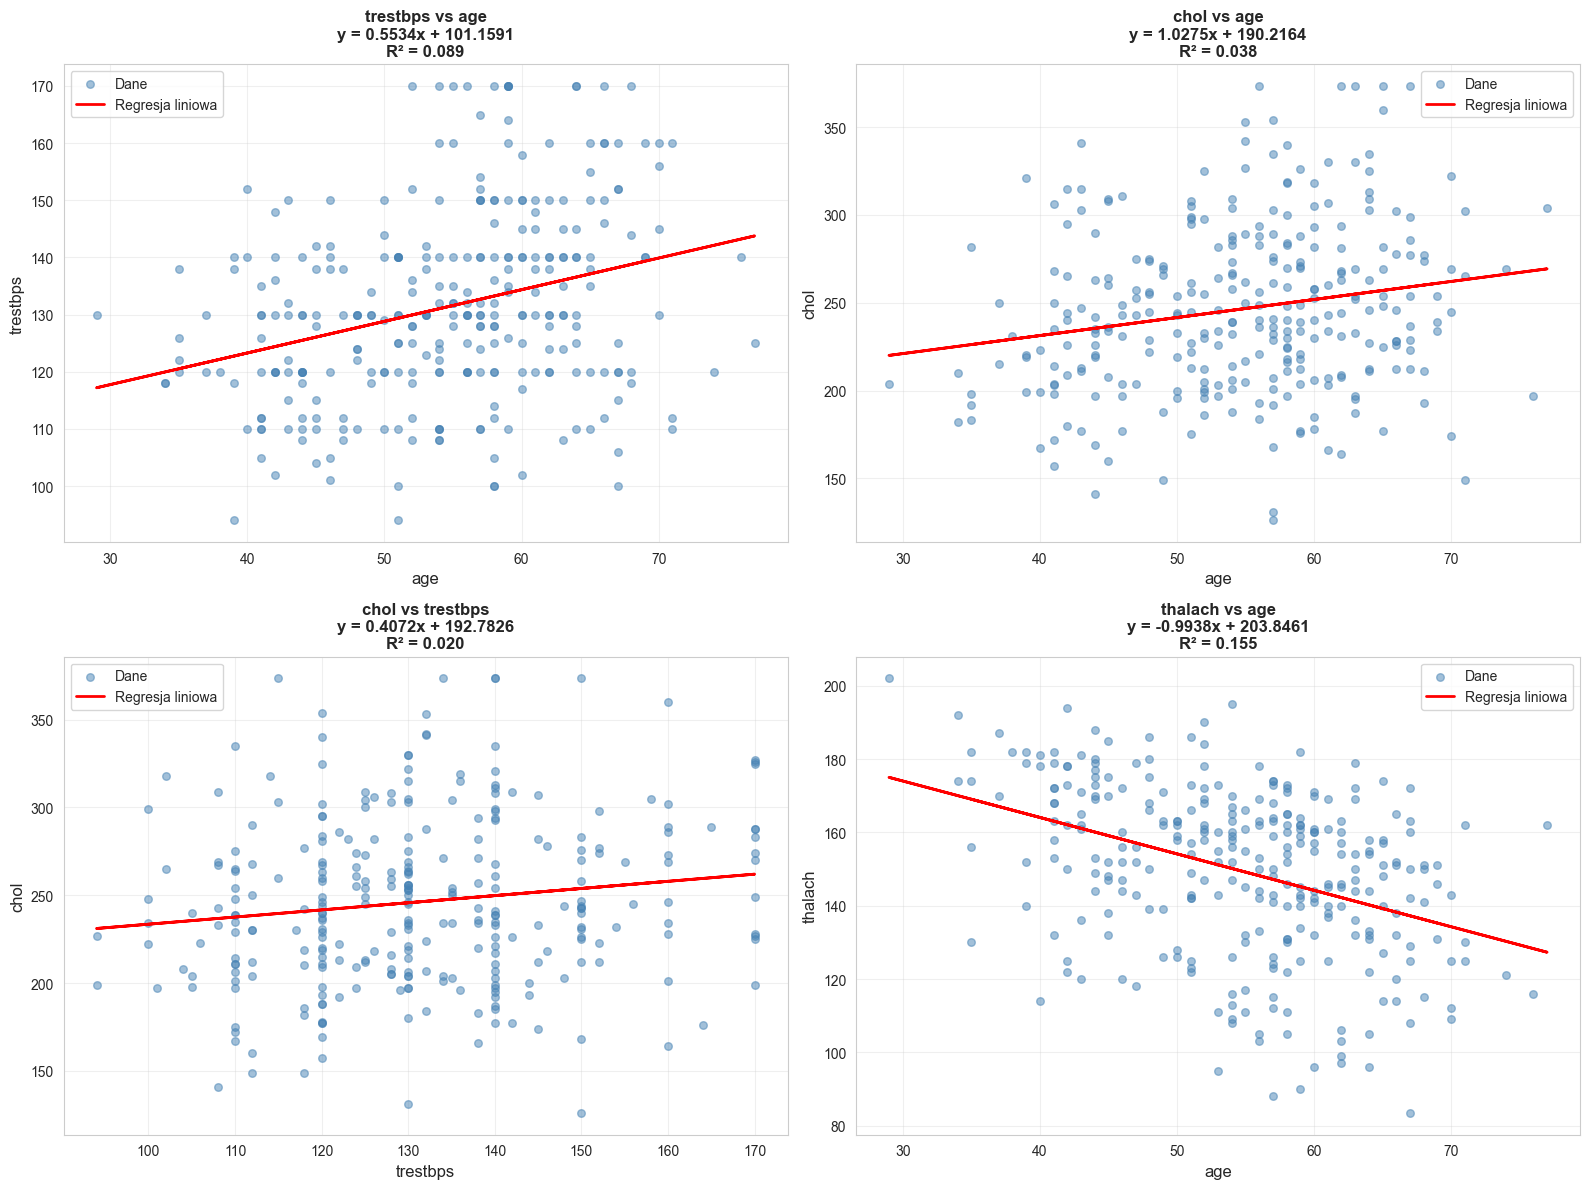

✓ Wykres zapisany: heart_output/scatter_plots.png


In [94]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (pair_name, results) in enumerate(list(regression_results.items())[:4]):
    ax = axes[idx]
    
    ax.scatter(results['X'], results['y'], alpha=0.5, s=30, color='steelblue', label='Dane')
    
    ax.plot(results['X'], results['y_pred'], color='red', linewidth=2, label='Regresja liniowa')
    
    x_col, y_col = pair_name.split('~')[1], pair_name.split('~')[0]
    ax.set_xlabel(x_col, fontsize=12)
    ax.set_ylabel(y_col, fontsize=12)
    ax.set_title(f'{y_col} vs {x_col}\n{results["formula"]}\nR² = {results["r2_score"]:.3f}', 
                 fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}/scatter_plots.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Wykres zapisany: {output_dir}/scatter_plots.png")

## 7. Podsumowanie analizy

In [95]:
print("="*80)
print("7. PODSUMOWANIE ANALIZY")
print("="*80)

print(f"""
RAPORT Z ANALIZY DANYCH
========================

1. Dataset: {df.shape[0]} rekordów, {df.shape[1]} zmiennych

2. Czyszczenie danych:
   - Uzupełnione kolumny: {len(cleaning_report['values_imputed'])}
   - Kolumny z outliers: {len(cleaning_report['outliers_removed'])}

3. Statystyki opisowe:
   - Obliczono dla {len(stats_df.columns)} zmiennych numerycznych
   - Zakres wartości, średnie, mediany, kwartyle, kwantyle

4. Korelacje:
   - Macierz korelacji Pearsona obliczona
   - Zidentyfikowano silne korelacje

5. Regresja liniowa:
   - Wykonano {len(regression_results)} regresji
   - Wyznaczono wzory regresji i współczynniki

6. Wizualizacje:
   ✓ Wykresy kołowe i słupkowe
   ✓ Szeregi czasowe
   ✓ Histogramy
   ✓ Wykresy pudełkowe
   ✓ Wykresy wiolinowe
   ✓ Wykresy rozrzutu z regresją liniową

Wszystkie wykresy i statystyki zostały zapisane w folderze: {output_dir}/
""")

print("\n" + "="*80)
print("ANALIZA ZAKOŃCZONA POMYŚLNIE!")
print("="*80)

7. PODSUMOWANIE ANALIZY

RAPORT Z ANALIZY DANYCH

1. Dataset: 297 rekordów, 14 zmiennych

2. Czyszczenie danych:
   - Uzupełnione kolumny: 0
   - Kolumny z outliers: 7

3. Statystyki opisowe:
   - Obliczono dla 14 zmiennych numerycznych
   - Zakres wartości, średnie, mediany, kwartyle, kwantyle

4. Korelacje:
   - Macierz korelacji Pearsona obliczona
   - Zidentyfikowano silne korelacje

5. Regresja liniowa:
   - Wykonano 4 regresji
   - Wyznaczono wzory regresji i współczynniki

6. Wizualizacje:
   ✓ Wykresy kołowe i słupkowe
   ✓ Szeregi czasowe
   ✓ Histogramy
   ✓ Wykresy pudełkowe
   ✓ Wykresy wiolinowe
   ✓ Wykresy rozrzutu z regresją liniową

Wszystkie wykresy i statystyki zostały zapisane w folderze: heart_output/


ANALIZA ZAKOŃCZONA POMYŚLNIE!
